## Mask Detector using Tensorflow, Keras, OPENCV, Python

### Pipeline 
- Load dataset
- Train Tensorflow/Keras model on dataset
- Serialize the model to local storage 

### Import Required Libraries

In [1]:
import os
import cv2
import json
import argparse 
import tensorflow
import numpy as np
import matplotlib.pyplot as plt
import skimage
from tensorflow.keras import Input
from tensorflow.keras.models import Model, model_from_json
from tensorflow.keras.layers import Flatten, Dense, AveragePooling2D, Conv2D, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.metrics import classification_report

### Path Declarations

In [2]:
BASE_DIR = "./data"

In [3]:
if os.path.exists("models") == False:
    os.mkdir("models")
    
if os.path.exists("checkpoints") == False:
    os.mkdir("checkpoints")

In [4]:
ls

 Volume in drive C has no label.
 Volume Serial Number is 384A-CD53

 Directory of C:\Users\IT\Desktop\projects\maskdetector

01/09/2020  20:02    <DIR>          .
01/09/2020  20:02    <DIR>          ..
01/09/2020  12:34    <DIR>          .ipynb_checkpoints
01/09/2020  13:03    <DIR>          checkpoints
01/09/2020  13:12                35 class_indices.json
01/09/2020  13:07    <DIR>          data
01/09/2020  13:03    <DIR>          models
01/09/2020  20:02           276,279 training.ipynb
               2 File(s)        276,314 bytes
               6 Dir(s)  673,363,939,328 bytes free


#### Image Data Augmentation - for generalization

In [5]:
# Data augmentation for train dataset
train_datagen = ImageDataGenerator(
                                   rotation_range=20,
                                   rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   fill_mode='nearest')

# Data augmentation for validation dataset (We only need to rescale)
validation_datagen = ImageDataGenerator(rescale = 1./255)

### Load dataset from directory

In [6]:
print(os.listdir(os.path.join(BASE_DIR)))

['test', 'train', 'val']


In [24]:
# Specify the batch size as 32 (or 64, 128, 256 e.t.c)
BATCH_SIZE = 32

# Load train dataset from the train dataset parent directory
train_set_from_dir = train_datagen.flow_from_directory(os.path.join(BASE_DIR, 'train'),
                                                       target_size = (224,224),
                                                       batch_size = BATCH_SIZE,
                                                       class_mode = 'categorical'
                                                       )

# Load the validation dataset from the validation dataset parent directory
validation_set_from_dir = validation_datagen.flow_from_directory(os.path.join(BASE_DIR, 'val'),
                                                                 target_size = (224,224),
                                                                 batch_size = BATCH_SIZE,
                                                                 class_mode = 'categorical'
)

Found 1315 images belonging to 2 classes.
Found 142 images belonging to 2 classes.


In [25]:
class_indices = train_set_from_dir.class_indices
class_indices

{'with_mask': 0, 'without_mask': 1}

### Serializing class indices  to .json file

In [26]:
with open("./class_indices.json", "w") as f:
    json.dump(class_indices, f)

In [39]:
next(train_set_from_dir)[0].shape

(32, 224, 224, 3)

In [27]:
train_size = train_set_from_dir.n
val_size = validation_set_from_dir.n

### Showing random images from the loaded set

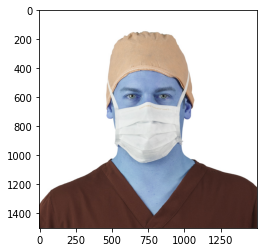

In [28]:
img = cv2.imread(train_set_from_dir.filepaths[np.random.randint(low=0, high = train_set_from_dir.n)])
plt.imshow(img)

(254, 198, 3)


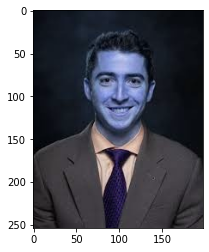

In [33]:
img = cv2.imread(validation_set_from_dir.filepaths[np.random.randint(low=0, high = validation_set_from_dir.n)])
plt.imshow(img)
print(img.shape)

### Building and training the MobileNetV2 model

In [50]:
# Loading the MobileNetV2 model with imagenet weights
# Ensure that the head fully connected layers are turned off
baseModel = MobileNetV2(
    input_shape = (224,224,3),
    include_top = False,
    weights = "imagenet"
)


In [51]:
baseModel.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [52]:
# Building the headModel on the baseModel

headModel = baseModel.output
headModel = AveragePooling2D(pool_size = (7,7))(headModel)
headModel = Flatten(name = "flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [53]:
# Placing the Fully connected headModel on the baseModel 

model = Model(inputs=baseModel.input, outputs=headModel)

In [54]:
# Freezing all the layers in the baseModel so their weights will not be updated during backpropagation

for layer in baseModel.layers:
    layer.trainable = False

### View Model Summary

In [55]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
____________________________________________________________________________________________

### Compiling the model

In [56]:
INIT_LR = 1e-4
N_EPOCHS = 10

# Declaring callbacks
callbacks = [
    EarlyStopping(monitor = "val_loss", patience = 5, verbose = 1 ),
    ModelCheckpoint(filepath='./checkpoints/mobilenet_checkpoint.h5', monitor='val_loss'), 
    ReduceLROnPlateau(factor=0.1, patience=10, min_lr=0.00001, verbose=1) 
]

# Compiling the model
model.compile(
    loss = ['binary_crossentropy'], 
    optimizer = Adam(learning_rate = INIT_LR,
                    decay = INIT_LR // N_EPOCHS),
    metrics = ['accuracy']
)


### Fitting the model on training and validation data

In [57]:
history = model.fit(
    train_set_from_dir, 
    validation_data = validation_set_from_dir, 
    epochs = N_EPOCHS, 
    steps_per_epoch = train_size//BATCH_SIZE, 
    validation_steps = val_size//BATCH_SIZE, 
    callbacks = callbacks
)

Train for 41 steps, validate for 4 steps
Epoch 1/10
41/41 [==============================] - 850s 21s/step - loss: 0.5502 - accuracy: 0.7108 - val_loss: 0.2881 - val_accuracy: 0.9609
Epoch 2/10
41/41 [==============================] - 1000s 24s/step - loss: 0.3701 - accuracy: 0.8402 - val_loss: 0.1543 - val_accuracy: 0.9922
Epoch 3/10
41/41 [==============================] - 952s 23s/step - loss: 0.2626 - accuracy: 0.9026 - val_loss: 0.1008 - val_accuracy: 0.9922
Epoch 4/10
41/41 [==============================] - 1087s 27s/step - loss: 0.2309 - accuracy: 0.9018 - val_loss: 0.0711 - val_accuracy: 0.9922
Epoch 5/10
41/41 [==============================] - 719s 18s/step - loss: 0.1926 - accuracy: 0.9306 - val_loss: 0.0707 - val_accuracy: 0.9922
Epoch 6/10
41/41 [==============================] - 963s 23s/step - loss: 0.1651 - accuracy: 0.9392 - val_loss: 0.0635 - val_accuracy: 0.9844
Epoch 7/10
41/41 [==============================] - 854s 21s/step - loss: 0.1482 - accuracy: 0.9509 - val

### Performance plot

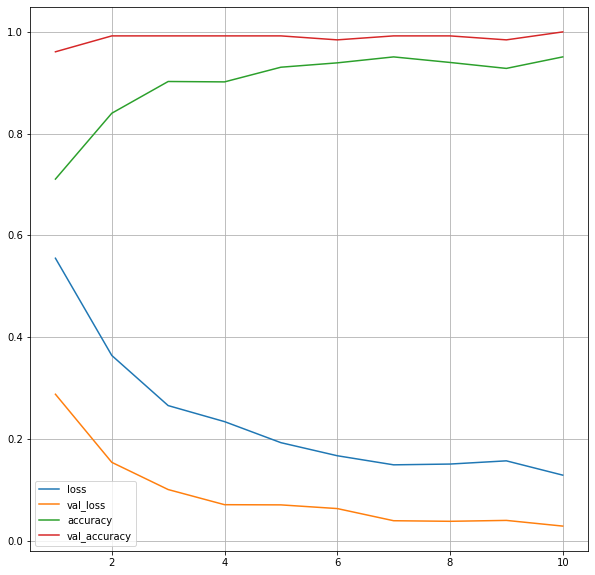

In [158]:
plt.figure(figsize = (10,10))
plt.plot(np.arange(1,N_EPOCHS+1), history.history['loss'], label = 'loss')
plt.plot(np.arange(1,N_EPOCHS+1), history.history['val_loss'], label = 'val_loss')
plt.plot(np.arange(1,N_EPOCHS+1), history.history['accuracy'], label = 'accuracy')
plt.plot(np.arange(1,N_EPOCHS+1), history.history['val_accuracy'], label = 'val_accuracy')

plt.legend(loc='best')
plt.grid(True)
plt.savefig('performance.jpg')
plt.show()

### Evaluating the model

In [59]:
(val_loss, val_accuracy) = model.evaluate_generator(validation_set_from_dir)

In [70]:
print(" ".join(["Accuracy:-", str(val_accuracy)]))
print("".join(["Loss:- ", str(val_loss)]))

Accuracy:- 1.0
Loss:- 0.02489407155662775


In [73]:
preds = model.predict(validation_set_from_dir)

In [76]:
np.argmax(preds, axis=1)

array([1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1,
       1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 0, 1, 1, 0, 1, 1], dtype=int64)

### Serializing the model to disk

In [86]:
model.save('./models/model.h5')

### Testing the model

In [151]:
test_preds = []
for i in os.listdir('./data/test/without_mask'):
    img = cv2.imread(os.path.join('./data/test/without_mask',i), cv2.IMREAD_UNCHANGED)
    resized_img = cv2.resize(img, (224,224), interpolation = cv2.INTER_AREA)
    img = np.expand_dims((resized_img/255.0).astype(float), axis=0)
    pred = model.predict(img)
    test_preds.append(pred)

In [146]:
test_preds = np.asarray(list(map(np.argmax, np.asarray(test_preds))))

In [150]:
sum(test_preds == 0)/len(test_preds)

0.041237113402061855

In [161]:
np.round(2.122344,2)

2.12

In [163]:
list(zip([1,2,4],[3,4,5]))

[(1, 3), (2, 4), (4, 5)]